In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
import gpflux
import gpflow
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data

tf.keras.backend.set_floatx("float64")

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)
x = x.numpy().reshape(-1,1)
y = y.numpy().reshape(-1,1)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

x_train = x_train.numpy().reshape(-1,1)
y_train = y_train.numpy().reshape(-1,1)
x_test = x_test.numpy().reshape(-1,1)
y_test = y_test.numpy().reshape(-1,1)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-02 10:51:14.293259: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 10:51:14.959350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [5]:
def plot_model(X, Y, mean, var, pos, labels):
    plt.figure(figsize=(20,5))
    plt.plot(X, Y, '.', label='true data', c='black', markersize=3)
    plt.plot(X, mean, '-', label='Mean predictive posterior', c='C0', linewidth=3)
    c = 1.96 * np.sqrt(var) 
    plt.fill_between(X[:,0], (mean-c), (mean+c), alpha=0.4, edgecolor='gray', facecolor='C0')
    plt.xticks(pos, labels)
    plt.xlabel('Date')
    plt.ylabel('Births')
    plt.legend()
    plt.show()

# Deep GP model

Let's first try running a two layer model to test the model.

inducing points = 1000 and RBF kernels for both layers.

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4057610/4262274600.py:30: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))


Fitted values MSE, MAE:  0.48723375933837926 0.5856106854336527
ELBO:  -11491.117153400546


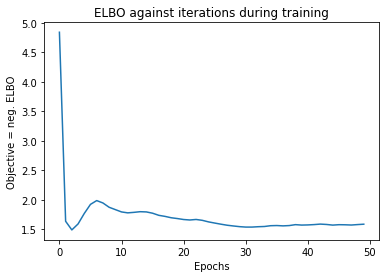

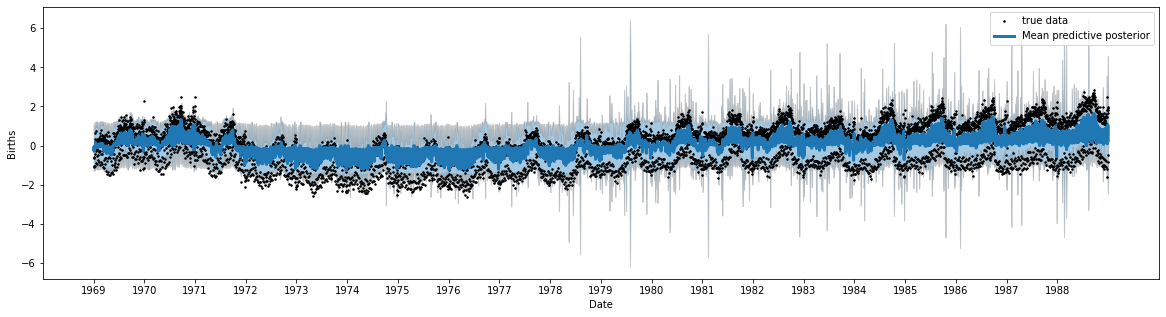

In [7]:
num_inducing = 1000

Z = np.linspace(x.min(), x.max(), num_inducing).reshape(-1, 1)

# layer 1 set up
kernel1 = gpflow.kernels.Matern52()
inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer1 = gpflux.layers.GPLayer(
    kernel1, 
    inducing_variable1, 
    num_data=len(x), 
    num_latent_gps=y.shape[1], 
    mean_function=gpflow.mean_functions.Identity()
)

# layer 2 set up
kernel2 = gpflow.kernels.RBF() 
inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer2 = gpflux.layers.GPLayer(
    kernel2,
    inducing_variable2,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero()
)

# model construction
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)

model = two_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.1))

history = model.fit({"inputs": x, "targets": y}, batch_size=500, epochs=50, verbose=0)
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Objective = neg. ELBO")
plt.title('ELBO against iterations during training')

model = two_layer_dgp.as_prediction_model()
output = model(x)
mu = output.f_mean.numpy().squeeze()
var = output.f_var.numpy().squeeze()

print('Fitted values MSE, MAE: ', mean_squared_error(y, mu), mean_absolute_error(y, mu))
print('ELBO: ', two_layer_dgp.elbo((x,y)).numpy())
plot_model(x, y, mu, var, pos, labels)

# Train/ Test Split

In [32]:
def build_train_2layer_dgp(kernel1, kernel2, callbacks=None, num_inducing=1000, batch_size=500):
    Z = np.linspace(x_train.min(), x_train.max(), num_inducing).reshape(-1, 1)

    # layer 1 set up
    inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer1 = gpflux.layers.GPLayer(
        kernel1, 
        inducing_variable1, 
        num_data=len(x_train), 
        num_latent_gps=y.shape[1]
    )

    # layer 2 set up
    inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer2 = gpflux.layers.GPLayer(
        kernel2,
        inducing_variable2,
        num_data=len(x_train),
        num_latent_gps=y.shape[1],
        mean_function=gpflow.mean_functions.Zero()
    )

    # model construction
    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
    two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)

    model = two_layer_dgp.as_training_model()
    model.compile(tf.optimizers.Adam(0.1))

    if callbacks:
        history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=50, verbose=0, callbacks=callbacks)
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].plot(history.history["loss"])
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Objective = neg. ELBO")
        ax[0].set_title('ELBO during training')
        ax[1].plot(history.history["lr"])
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Learning rate")
        ax[1].set_title('Learning rate during training')
        plt.show()
    else:
        history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=50, verbose=0)
        plt.plot(history.history["loss"])
        plt.xlabel("Epochs")
        plt.ylabel("Objective = neg. ELBO")
        plt.title('ELBO during training')
        plt.show()

    model = two_layer_dgp.as_prediction_model()

    print('Training Set')
    fitted_values = model(x_train)
    mean_train = fitted_values.f_mean.numpy().squeeze()
    var_train = fitted_values.f_var.numpy().squeeze()
    plot_model(x_train, y_train, mean_train, var_train, pos, labels)

    print('Testing Set')
    pred = model(x_test)
    mean_test = pred.f_mean.numpy().squeeze()
    var_test = pred.f_var.numpy().squeeze()
    plot_model(x_test, y_test, mean_test, var_test, pos, labels)

    print('Train ELBO, MSE, MAE: ', two_layer_dgp.elbo((x_train, y_train)).numpy(), 
                                    mean_squared_error(y_train, mean_train), 
                                    mean_absolute_error(y_train, mean_train))

    print('Test ELBO, MSE, MAE: ', two_layer_dgp.elbo((x_test, y_test)).numpy(), 
                                    mean_squared_error(y_test, mean_test), 
                                    mean_absolute_error(y_test, mean_test))

    print_summary(two_layer_dgp, fmt="notebook")

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4057610/1684544756.py:24: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2

Training Set


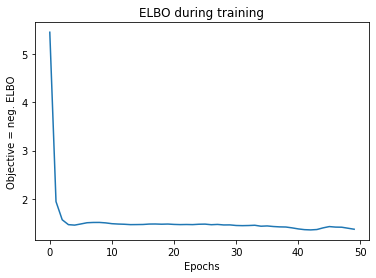

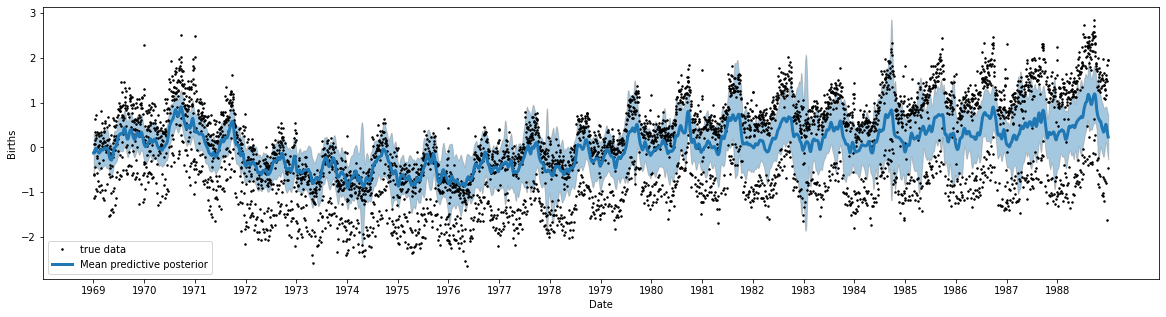

Testing Set


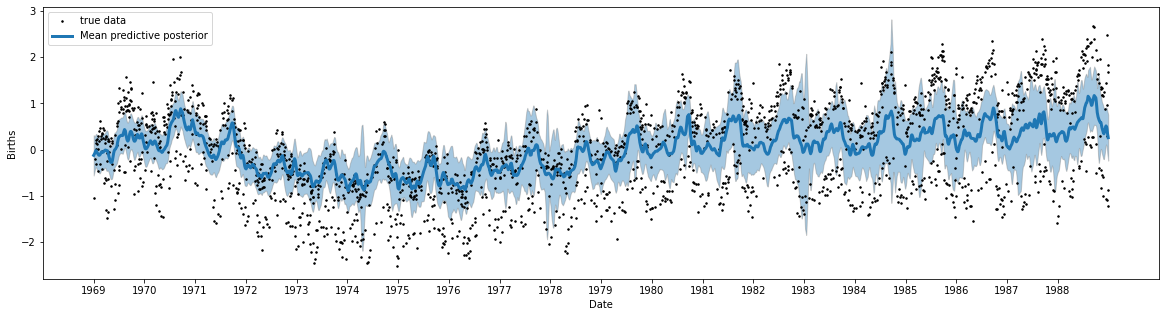

Train ELBO, MSE, MAE:  -7030.579287294453 0.5890935472549766 0.6435991119250987
Test ELBO, MSE, MAE:  -7321.205221274006 0.668520549197368 0.6888837175270791


In [10]:
# No callbacks
kernel1 = gpflow.kernels.RBF()
kernel2 = gpflow.kernels.Matern52()

build_train_2layer_dgp(kernel1, kernel2, num_inducing=2000)

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4057610/470990103.py:24: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.

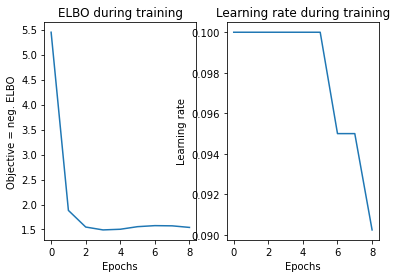

Training Set


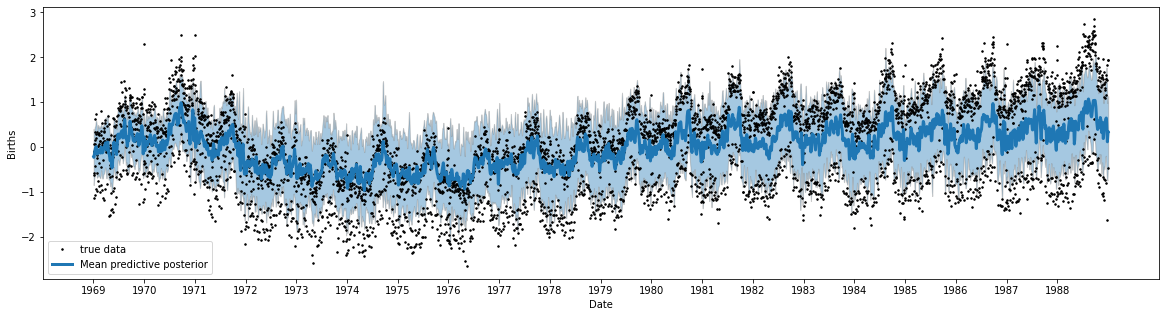

Testing Set


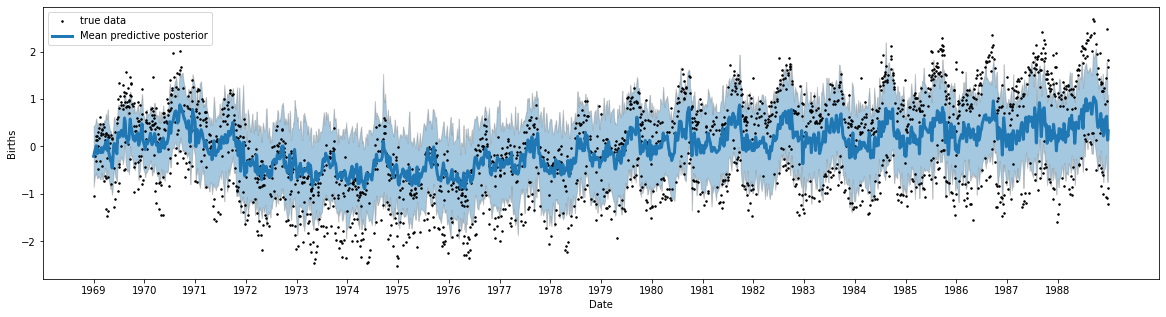

Train ELBO, MSE, MAE:  -7775.443535808148 0.573067211577274 0.6339938855276459
Test ELBO, MSE, MAE:  -8435.56354149649 0.7468388403610097 0.7296538947165526


In [19]:
# using callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
]

kernel1 = gpflow.kernels.Periodic(gpflow.kernels.RBF())
kernel2 = gpflow.kernels.RBF()

build_train_2layer_dgp(kernel1, kernel2, num_inducing=2000, callbacks=callbacks, batch_size=500)

Let's now try a 3 layer DGP.

In [29]:
def build_train_3layer_dgp(kernel1, kernel2, kernel3, callbacks=None, num_inducing=1000, batch_size=500):
    Z = np.linspace(x_train.min(), x_train.max(), num_inducing).reshape(-1, 1)

    # layer 1 set up
    inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer1 = gpflux.layers.GPLayer(
        kernel1, 
        inducing_variable1, 
        num_data=len(x_train), 
        num_latent_gps=y.shape[1]
    )

    # layer 2 set up
    inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer2 = gpflux.layers.GPLayer(
        kernel2,
        inducing_variable2,
        num_data=len(x_train),
        num_latent_gps=y.shape[1], 
        mean_function=gpflow.mean_functions.Zero()
    )

    # layer 3 set up
    inducing_variable3 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer3 = gpflux.layers.GPLayer(
        kernel3,
        inducing_variable3,
        num_data=len(x_train),
        num_latent_gps=y.shape[1]
    )

    # model construction
    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
    three_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2, gp_layer3], likelihood_layer)

    model = three_layer_dgp.as_training_model()
    model.compile(tf.optimizers.Adam(0.1))

    if callbacks:
        history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=50, verbose=0, callbacks=callbacks)
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].plot(history.history["loss"])
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Objective = neg. ELBO")
        ax[0].set_title('ELBO during training')
        ax[1].plot(history.history["lr"])
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Learning rate")
        ax[1].set_title('Learning rate during training')
        plt.show()
    else:
        history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=50, verbose=0)
        plt.plot(history.history["loss"])
        plt.xlabel("Epochs")
        plt.ylabel("Objective = neg. ELBO")
        plt.title('ELBO during training')
        plt.show()

    model = three_layer_dgp.as_prediction_model()

    print('Training Set')
    fitted_values = model(x_train)
    mean_train = fitted_values.f_mean.numpy().squeeze()
    var_train = fitted_values.f_var.numpy().squeeze()
    plot_model(x_train, y_train, mean_train, var_train, pos, labels)

    print('Testing Set')
    pred = model(x_test)
    mean_test = pred.f_mean.numpy().squeeze()
    var_test = pred.f_var.numpy().squeeze()
    plot_model(x_test, y_test, mean_test, var_test, pos, labels)

    print('Train ELBO, MSE, MAE: ', three_layer_dgp.elbo((x_train, y_train)).numpy(), 
                                    mean_squared_error(y_train, mean_train), 
                                    mean_absolute_error(y_train, mean_train))

    print('Test ELBO, MSE, MAE: ', three_layer_dgp.elbo((x_test, y_test)).numpy(), 
                                    mean_squared_error(y_test, mean_test), 
                                    mean_absolute_error(y_test, mean_test))
    
    #print_summary(three_layer_dgp, fmt="notebook")

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4057610/1667748621.py:33: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2

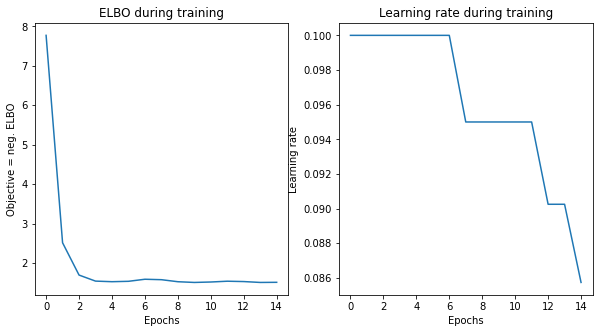

Training Set


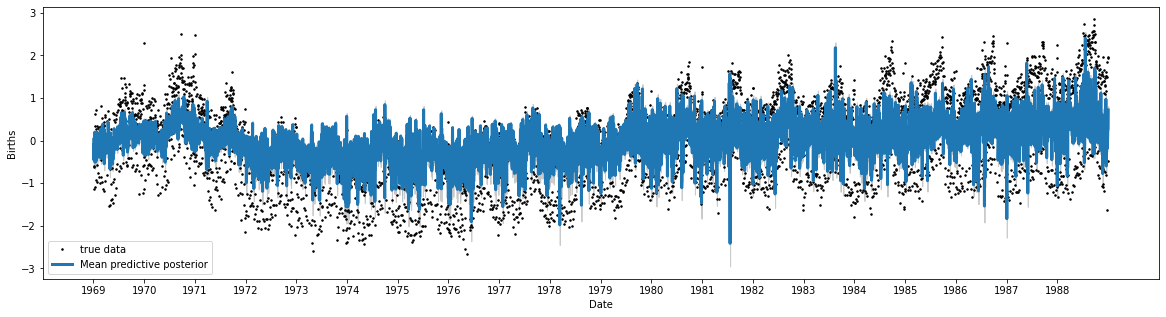

Testing Set


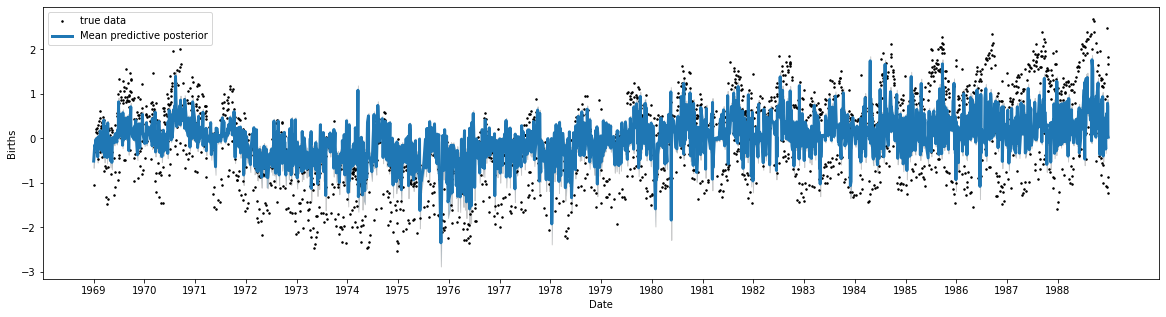

Train ELBO, MSE, MAE:  -7790.2360051165015 0.7936123896219729 0.7271185118132886
Test ELBO, MSE, MAE:  -8027.054516518935 0.8796033853996612 0.7702376502195143


In [30]:
# using callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
]

kernel1 = gpflow.kernels.Periodic(gpflow.kernels.RBF())
kernel2 = gpflow.kernels.RBF()
kernel3 = gpflow.kernels.RBF()

build_train_3layer_dgp(kernel1, kernel2, kernel3, num_inducing=1000, callbacks=callbacks, batch_size=500)

With 3 layers it seems to overfit.

GO back to 2 layers and try to improve fit by changing:

        - mean function
        - inducing variables
        - kernels

Idea: try and not train period in periodic like in GPFlow models.

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4057610/764222103.py:24: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.

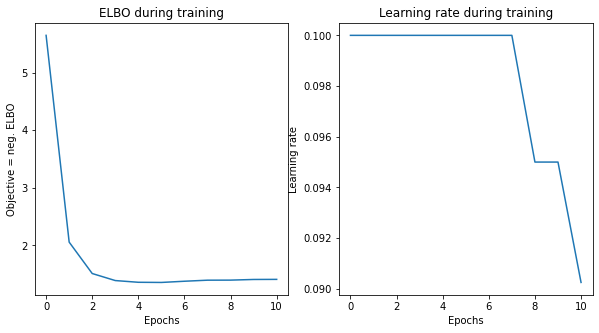

Training Set


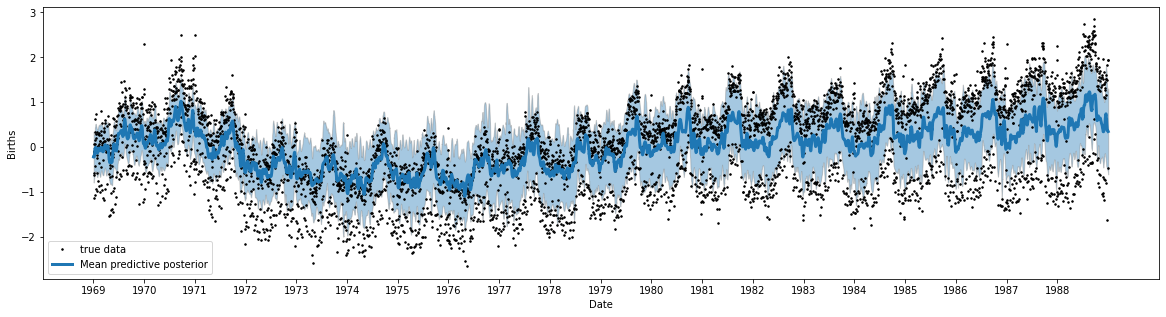

Testing Set


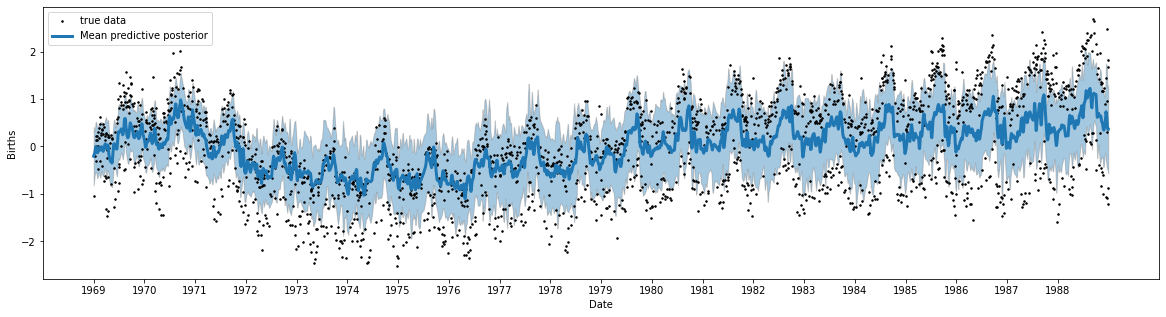

Train ELBO, MSE, MAE:  -7153.257454295341 0.5633812916556871 0.628235502871388
Test ELBO, MSE, MAE:  -7644.91035924835 0.6891128385756119 0.6993419515784765


name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[-7.05912079e-02...
DeepGP.f_layers[0]._trainable_weights[1],ResourceVariable,,,True,"(1, 500500)",float64,"[[9.99971058e-01, -3.62124894e-04, 1.22219957e-04..."
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[0] DeepGP.f_layers[0]._metrics[0].total,ResourceVariable,,,False,(),float64,0.0016362032865818415
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[1] DeepGP.f_layers[0]._metrics[0].count,ResourceVariable,,,False,(),float64,15.0
DeepGP.f_layers[0]._self_tracked_trackables[1].base_kernel.variance DeepGP.f_layers[0].kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,0.47306938261686177
DeepGP.f_layers[0]._self_tracked_trackables[1].base_kernel.lengthscales DeepGP.f_layers[0].kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.5742564175589225
DeepGP.f_layers[0]._self_tracked_trackables[1].period DeepGP.f_layers[0].kernel.period,Parameter,Softplus,,True,(),float64,0.2943042533679367
DeepGP.f_layers[0]._self_tracked_trackables[2].Z DeepGP.f_layers[0].inducing_variable.Z,Parameter,Identity,,True,"(1000, 1)",float64,[[-2.62216608e-01...
DeepGP.f_layers[0]._self_tracked_trackables[4] DeepGP.f_layers[0].q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[-7.05912079e-02...
DeepGP.f_layers[0]._self_tracked_trackables[5] DeepGP.f_layers[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[7.98661170e-01, 0.00000000e+00, 0.00000000e+00..."


In [36]:
# RBF and periodic
# not changing anything

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
]

kernel1 = gpflow.kernels.Periodic(gpflow.kernels.RBF())
kernel2 = gpflow.kernels.RBF()

build_train_2layer_dgp(kernel1, kernel2, num_inducing=1000, callbacks=callbacks, batch_size=500)

Errors of about 0.7

Try changing period first, by setting the starting value at 365.25

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4057610/764222103.py:24: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.

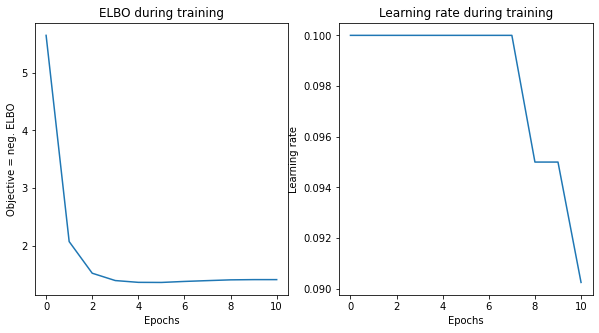

Training Set


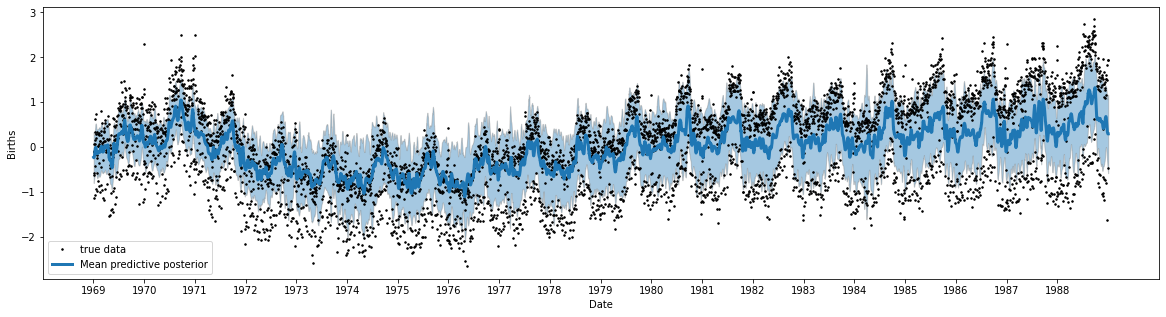

Testing Set


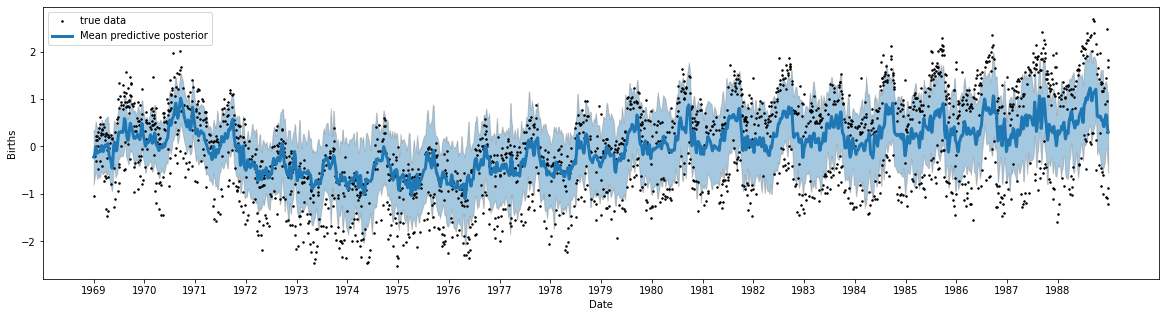

Train ELBO, MSE, MAE:  -7170.121407798512 0.563620785399965 0.62850768495039
Test ELBO, MSE, MAE:  -7652.070932405534 0.6890582841549535 0.6991980292325662


name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[-1.45813702e-01...
DeepGP.f_layers[0]._trainable_weights[1],ResourceVariable,,,True,"(1, 500500)",float64,"[[1.00003682e+00, 2.16338863e-04, -6.13280439e-05..."
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[0] DeepGP.f_layers[0]._metrics[0].total,ResourceVariable,,,False,(),float64,0.004357399047425052
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[1] DeepGP.f_layers[0]._metrics[0].count,ResourceVariable,,,False,(),float64,15.0
DeepGP.f_layers[0]._self_tracked_trackables[1].base_kernel.variance DeepGP.f_layers[0].kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,0.7944036208540272
DeepGP.f_layers[0]._self_tracked_trackables[1].base_kernel.lengthscales DeepGP.f_layers[0].kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.595652569714239
DeepGP.f_layers[0]._self_tracked_trackables[1].period DeepGP.f_layers[0].kernel.period,Parameter,Softplus,,True,(),float64,365.4913953543993
DeepGP.f_layers[0]._self_tracked_trackables[2].Z DeepGP.f_layers[0].inducing_variable.Z,Parameter,Identity,,True,"(1000, 1)",float64,[[1.66320965e+00...
DeepGP.f_layers[0]._self_tracked_trackables[4] DeepGP.f_layers[0].q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[-1.45813702e-01...
DeepGP.f_layers[0]._self_tracked_trackables[5] DeepGP.f_layers[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[5.67098547e-01, 0.00000000e+00, 0.00000000e+00..."


In [37]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
]

kernel1 = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25)
kernel2 = gpflow.kernels.RBF()

build_train_2layer_dgp(kernel1, kernel2, num_inducing=1000, callbacks=callbacks, batch_size=500)

The period remains near the selected starting position. Error still around 0.7.

Change starting conditions. Specially lengthscale, set starting point to 5.

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4057610/764222103.py:24: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.

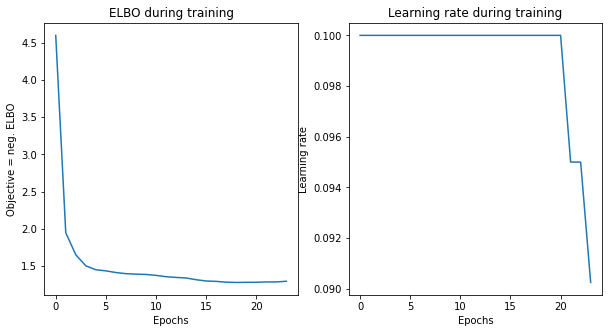

Training Set


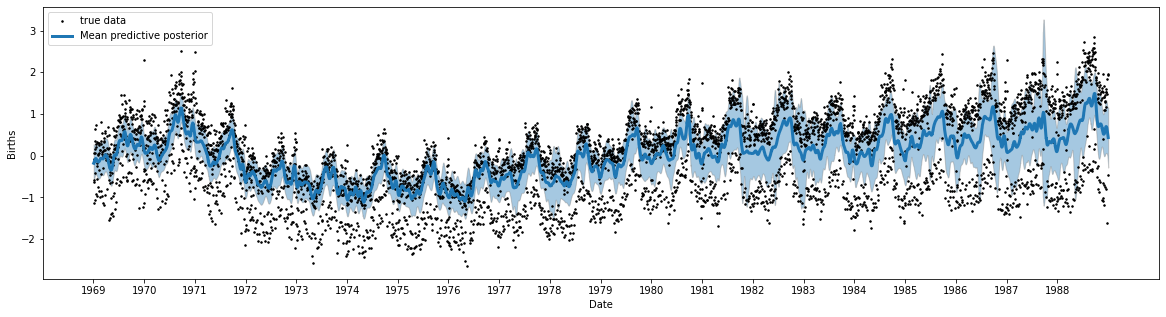

Testing Set


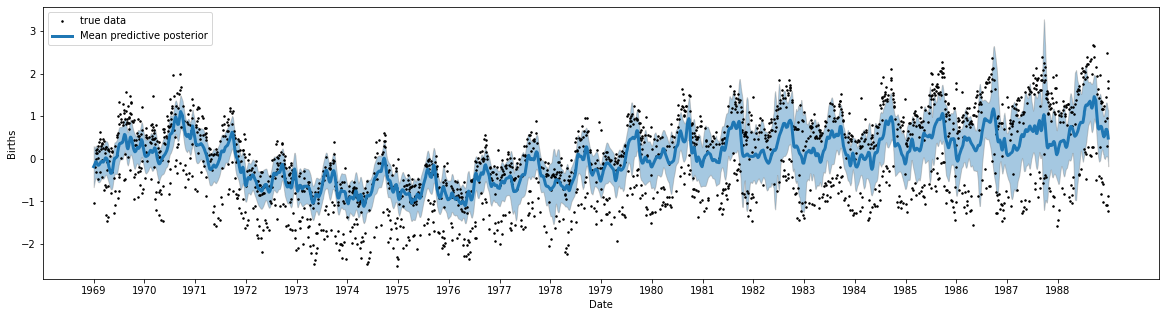

Train ELBO, MSE, MAE:  -6611.542094271835 0.5483009117819483 0.6220806547512732
Test ELBO, MSE, MAE:  -6983.542957154723 0.6323189087632988 0.66946271194385


name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[2.38458675e+00...
DeepGP.f_layers[0]._trainable_weights[1],ResourceVariable,,,True,"(1, 500500)",float64,"[[1.00000444e+00, -3.31338100e-05, -6.07356917e-05..."
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[0] DeepGP.f_layers[0]._metrics[0].total,ResourceVariable,,,False,(),float64,0.010190768452807612
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[1] DeepGP.f_layers[0]._metrics[0].count,ResourceVariable,,,False,(),float64,15.0
DeepGP.f_layers[0]._self_tracked_trackables[1].base_kernel.variance DeepGP.f_layers[0].kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,3.0622211132209607
DeepGP.f_layers[0]._self_tracked_trackables[1].base_kernel.lengthscales DeepGP.f_layers[0].kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.37919030119698
DeepGP.f_layers[0]._self_tracked_trackables[1].period DeepGP.f_layers[0].kernel.period,Parameter,Softplus,,True,(),float64,363.5081785373287
DeepGP.f_layers[0]._self_tracked_trackables[2].Z DeepGP.f_layers[0].inducing_variable.Z,Parameter,Identity,,True,"(1000, 1)",float64,[[2.08574256e+00...
DeepGP.f_layers[0]._self_tracked_trackables[4] DeepGP.f_layers[0].q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[2.38458675e+00...
DeepGP.f_layers[0]._self_tracked_trackables[5] DeepGP.f_layers[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[2.34151032e-01, 0.00000000e+00, 0.00000000e+00..."


In [38]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
]

kernel1 = gpflow.kernels.Periodic(gpflow.kernels.RBF(lengthscales=5), period=365.25)
kernel2 = gpflow.kernels.RBF(lengthscales=5)

build_train_2layer_dgp(kernel1, kernel2, num_inducing=1000, callbacks=callbacks, batch_size=500)

Slightly larger lengthscale improves the fit from about 0.7 to 0.63 in MSE.

Try larger lengthscales. lengthscales = 10

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4057610/764222103.py:24: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.

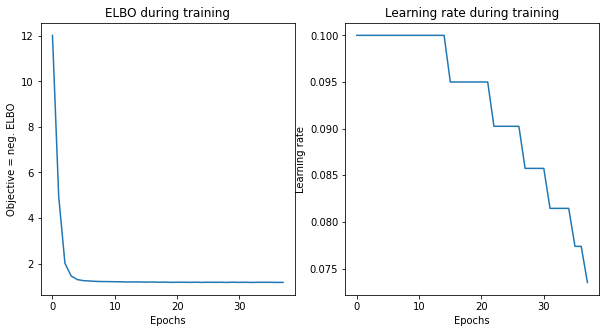

Training Set


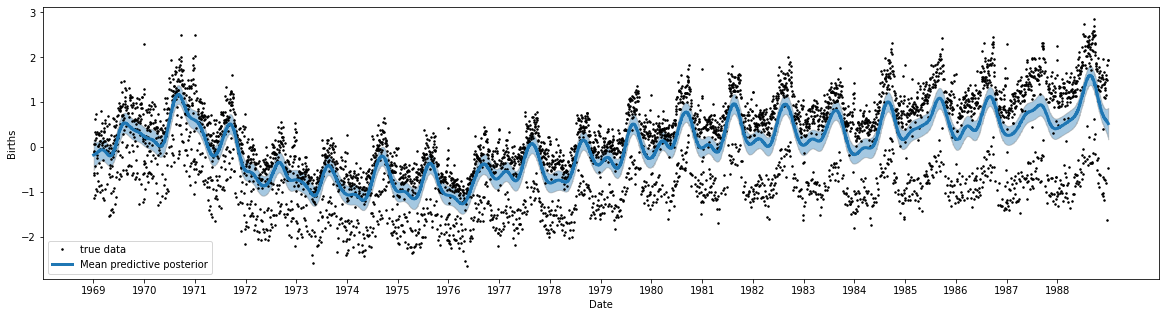

Testing Set


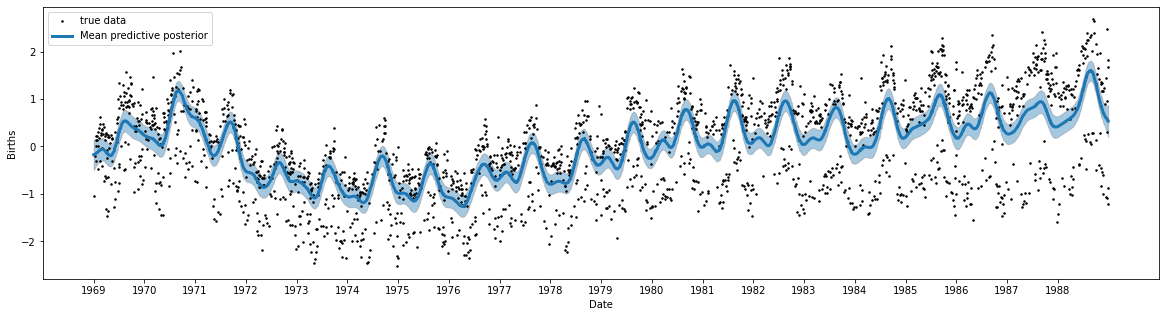

Train ELBO, MSE, MAE:  -5992.579838012498 0.5527643555161343 0.6243439011681107
Test ELBO, MSE, MAE:  -6151.463178214992 0.588577523680576 0.6446985464393619


name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[2.16376296e-02...
DeepGP.f_layers[0]._trainable_weights[1],ResourceVariable,,,True,"(1, 500500)",float64,"[[9.99855038e-01, -3.92540913e-09, 1.75505642e-07..."
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[0] DeepGP.f_layers[0]._metrics[0].total,ResourceVariable,,,False,(),float64,3.643230088571874e-05
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[1] DeepGP.f_layers[0]._metrics[0].count,ResourceVariable,,,False,(),float64,15.0
DeepGP.f_layers[0]._self_tracked_trackables[1].base_kernel.variance DeepGP.f_layers[0].kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,1.7326098395228746
DeepGP.f_layers[0]._self_tracked_trackables[1].base_kernel.lengthscales DeepGP.f_layers[0].kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,49.690090961774814
DeepGP.f_layers[0]._self_tracked_trackables[1].period DeepGP.f_layers[0].kernel.period,Parameter,Softplus,,True,(),float64,364.7193788713099
DeepGP.f_layers[0]._self_tracked_trackables[2].Z DeepGP.f_layers[0].inducing_variable.Z,Parameter,Identity,,True,"(1000, 1)",float64,[[1.97851554e+00...
DeepGP.f_layers[0]._self_tracked_trackables[4] DeepGP.f_layers[0].q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[2.16376296e-02...
DeepGP.f_layers[0]._self_tracked_trackables[5] DeepGP.f_layers[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[9.14027774e-01, 0.00000000e+00, 0.00000000e+00..."


In [40]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
]

kernel1 = gpflow.kernels.Periodic(gpflow.kernels.RBF(lengthscales=50), period=365.25)
kernel2 = gpflow.kernels.RBF(lengthscales=50)

build_train_2layer_dgp(kernel1, kernel2, num_inducing=1000, callbacks=callbacks, batch_size=500)

In [3]:
x, y = separate_data(data, normalised=True, weekdays=True)

x = x.numpy().reshape(-1,1)
y = y.numpy().reshape(-1,1)


def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4161898/2459611603.py:31: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2

Epoch 1/50
11/11 [==============================] - 4s 88ms/step - loss: 5.0215 - gp_layer_3_prior_kl: 0.0026 - gp_layer_4_prior_kl: 0.0212
Epoch 2/50
11/11 [==============================] - 1s 87ms/step - loss: 1.6719 - gp_layer_3_prior_kl: 0.0125 - gp_layer_4_prior_kl: 0.1238
Epoch 3/50
11/11 [==============================] - 1s 88ms/step - loss: 1.2012 - gp_layer_3_prior_kl: 0.0110 - gp_layer_4_prior_kl: 0.1879
Epoch 4/50
11/11 [==============================] - 1s 87ms/step - loss: 1.0892 - gp_layer_3_prior_kl: 0.0040 - gp_layer_4_prior_kl: 0.1760
Epoch 5/50
11/11 [==============================] - 1s 88ms/step - loss: 1.0571 - gp_layer_3_prior_kl: 0.0018 - gp_layer_4_prior_kl: 0.1690
Epoch 6/50
11/11 [==============================] - 1s 88ms/step - loss: 1.0630 - gp_layer_3_prior_kl: 0.0012 - gp_layer_4_prior_kl: 0.1787
Epoch 7/50
11/11 [==============================] - 1s 88ms/step - loss: 1.0978 - gp_layer_3_prior_kl: 9.4312e-04 - gp_layer_4_prior_kl: 0.2001
Epoch 8/50
11/11

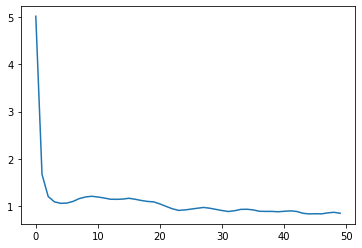

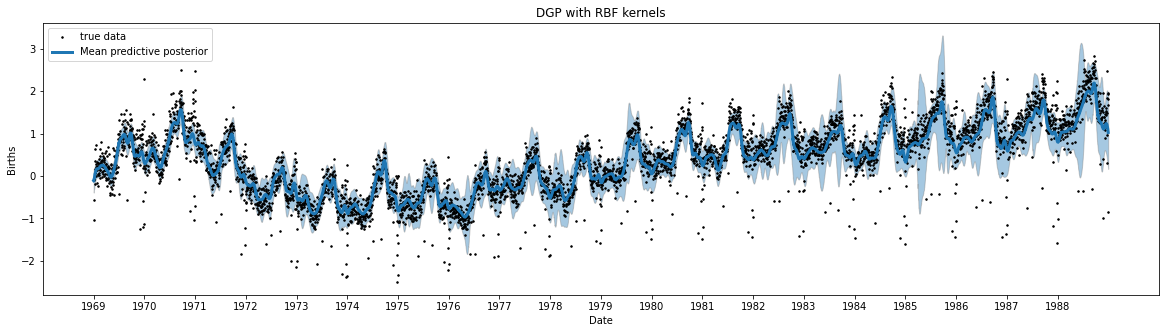

In [4]:
# from gpflux.architectures import Config, build_constant_input_dim_deep_gp
# from gpflux.models import DeepGP
num_inducing = 1000

Z = np.linspace(x.min(), x.max(), num_inducing).reshape(-1, 1)

kernel1 = gpflow.kernels.Matern52()
inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer1 = gpflux.layers.GPLayer(kernel1, inducing_variable1, num_data=len(x), num_latent_gps=y.shape[1])

kernel2 = gpflow.kernels.RBF() 
inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer2 = gpflux.layers.GPLayer(
    kernel2,
    inducing_variable2,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)

kernel3 = gpflow.kernels.RBF() 
inducing_variable3 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer3 = gpflux.layers.GPLayer(
    kernel3,
    inducing_variable3,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)

likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)

model = two_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.1))

history = model.fit({"inputs": x, "targets": y}, batch_size=500, epochs=50, verbose=1)
plt.plot(history.history["loss"])

model = two_layer_dgp.as_prediction_model()
output = model(x)
mu = output.f_mean.numpy().squeeze()
var = output.f_var.numpy().squeeze()

plt.figure(figsize=(20,5))
plt.plot(x, y, '.', label='true data', c='black', markersize=3)
plt.plot(x, mu, '-', label='Mean predictive posterior', c='C0', linewidth=3)
vv = 1.96 * np.sqrt(var) 
plt.fill_between(x[:,0], (mu-vv), (mu+vv), alpha=0.4, edgecolor='gray', facecolor='C0')
plt.title('DGP with RBF kernels' )
plt.xticks(pos, labels)
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()
plt.show()

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4161898/4003382949.py:47: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2

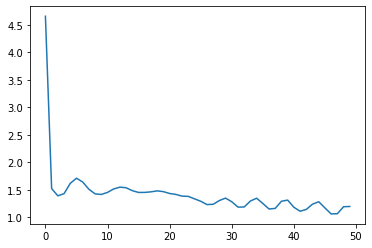

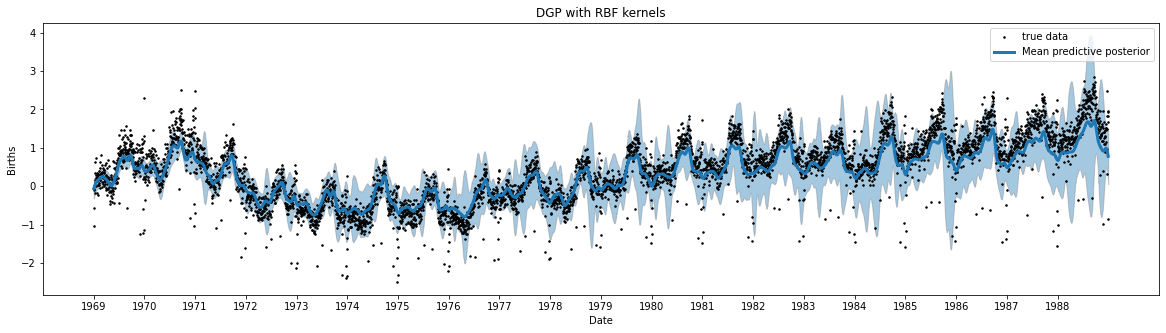

In [12]:
# from gpflux.architectures import Config, build_constant_input_dim_deep_gp
# from gpflux.models import DeepGP
x, y = separate_data(data, normalised=True, weekdays=True)

x = x.numpy().reshape(-1,1)
y = y.numpy().reshape(-1,1)


def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

num_inducing = 3000

Z = np.linspace(x.min(), x.max(), num_inducing).reshape(-1, 1)

kernel1 = gpflow.kernels.RBF() 
inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer1 = gpflux.layers.GPLayer(kernel1, inducing_variable1, num_data=len(x), num_latent_gps=y.shape[1])

kernel2 = gpflow.kernels.RBF()
inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer2 = gpflux.layers.GPLayer(
    kernel2,
    inducing_variable2,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)

kernel3 = gpflow.kernels.RBF() 
inducing_variable3 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer3 = gpflux.layers.GPLayer(
    kernel3,
    inducing_variable3,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)

likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)

model = two_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.1))

history = model.fit({"inputs": x, "targets": y}, batch_size=500, epochs=50, verbose=0)
plt.plot(history.history["loss"])

model = two_layer_dgp.as_prediction_model()
output = model(x)
mu = output.f_mean.numpy().squeeze()
var = output.f_var.numpy().squeeze()

plt.figure(figsize=(20,5))
plt.plot(x, y, '.', label='true data', c='black', markersize=3)
plt.plot(x, mu, '-', label='Mean predictive posterior', c='C0', linewidth=3)
vv = 1.96 * np.sqrt(var) 
plt.fill_between(x[:,0], (mu-vv), (mu+vv), alpha=0.4, edgecolor='gray', facecolor='C0')
plt.title('DGP with RBF kernels' )
plt.xticks(pos, labels)
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()
plt.show()